<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# <center> **SpaceX Falcon 9 first stage landing prediction.** <center>

## <center> Practical laboratory<center>


Space X advertises the Falcon 9 rocket launch on its website at a cost of $62 million; other providers cost over $165 million each. Much of the savings is because Space X can reuse the first stage. Therefore, if we can determine if the first stage will land, we can determine the cost of the launch. This information can be used if another company wants to bid against Space X for a rocket launch. In this lab, you will create a machine learning sequence to predict if the first stage will land, based on data from the previous labs.

![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Below are several examples of failed landings:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most successful landings are planned. SpaceX makes a controlled landing in the oceans.

## Objectives


Perform exploratory data analysis and determine training labels.

Workflow:
* Create a column for the class.
* Standardize the data.
* Split the data into training and test data.
* Find the best hyperparameter for SVM, classification trees, and logistic regression.
* Find the best performing method using test data.

## We will import libraries and define some helper functions


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Preprocessing allows us to standardize our data
from sklearn import preprocessing

# It allows us to split our data into training and test data.
from sklearn.model_selection import train_test_split

# It allows us to test classification algorithm parameters and find the best one
from sklearn.model_selection import GridSearchCV

# Logistic regression classification algorithm
from sklearn.linear_model import LogisticRegression

# Support vector machine classification algorithm
from sklearn.svm import SVC

# Decision tree classification algorithm
from sklearn.tree import DecisionTreeClassifier

# K-nearest neighbor classification algorithm
from sklearn.neighbors import KNeighborsClassifier

# Random Forest classification algorithm
from sklearn.ensemble import RandomForestClassifier

# classification report to evaluate the model and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

We will define a function to graph the confusion matrix.

<details>
In case you need a reminder:

What is a confusion matrix?
A confusion matrix is ​​a table that shows how many times a model was right or wrong when making predictions.
It divides the results into four groups:
✅ Hits when it predicted correctly, and ❌ Misses when it failed.

It's used to measure the quality of a classification model (for example, predicting whether a launch will be successful or not).
</details>

In [3]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); # annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show()

## Load the data frame


We'll use our latest datasets, which we've already worked with in previous labs.

We need to use datasets from parts 2 and 3.

We'll use dataset 2 because it has a "Class" column, while dataset 3 doesn't, but we still have our data already coded and processed.

In [4]:
# With this we detect the base path of the project from the notebook
# and then use it to load the dataset without having to use absolute paths
BASE_DIR = Path().resolve().parents[2]
file_path = BASE_DIR / "data" / "processed" / "dataset_part_2.csv"

data = pd.read_csv(file_path)

In [4]:
# If not, we should run the following command to load the dataset
# data = pd.read_csv("../../../data/processed/dataset_part_2.csv")

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


<details>
To simplify the process, IBM provided us with the same dataset but with updated details so as not to lose the achieved process.
<details>

We begin by determining our set of predictive features, in this case using our last clean dataset (dataset_part_3).

In [6]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## STEP 1

We'll create a NumPy array from a new <code>Class</code> column in <code>data</code> using the <code>to_numpy()</code> method and then assign it to the <code>Y</code> variable. We'll need to make sure the output is a Pandas array (just a single key df\['column name']).


In [8]:
Y = data['Class'].to_numpy()

IMPORTANT NOTE:

On this occasion, we will strategically combine two datasets, taking into account the following guidelines, which make this operation impossible (we will verify that the indexes match so that the data will be consistent when we create the new datasets). Under other conditions, the following practice is not recommended. However, we will proceed to complete this lab without losing any of the benefits of applying the beautiful modeling process at this stage of a data science project's lifecycle.

In [9]:
# We verify that both have the same number of rows
print(f"X shape: {X.shape[0]}, Y shape: {Y.shape[0]}")

# Verificamos si los índices son iguales
print("Remember that the indices of X (X shape and Y shape must be equal)")
print(f"Equal indexes? {X.index.equals(data.index)}")

X shape: 90, Y shape: 90
Remember that the indices of X (X shape and Y shape must be equal)
Equal indexes? True


## STEP 2


We will standardize the data in <code>X</code> and then reassign it to the variable <code>X</code> using the following transformation.

In [10]:
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and test data using the <code>train_test_split</code> function. The training data is split into validation data, and a second set is used for training data. The models are then trained and hyperparameters are selected using the <code>GridSearchCV</code> function.


## STEP 3


We will use the ``train_test_split`` function to split the X and Y data into training and test data. We set the test_size parameter to 0.2 and random_state to 2. The training and test data should be assigned the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

We can see that we only have 18 test samples.


In [12]:
Y_test.shape

(18,)

## STEP 4


We will create a logistic regression object and then create a GridSearchCV object <code>logreg_cv</code> with cv = 10. We tune the object to find the best parameters from the <code>parameters</code> dictionary.

In [14]:
parameters_lr = {
  "C": [0.01, 0.1, 1],         # Inverse regularization strength
  "penalty": ["l2"],           # Type of penalty (regularization)
  "solver": ["lbfgs"]          # Algorithm used for optimization
}                              # l1 lasso or l2 ridge
lr = LogisticRegression()

In [15]:
lr_cv = GridSearchCV(lr,parameters_lr,cv=10)
lr_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We generate the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the <code>best_params</code> data attribute and the validation data accuracy using the <code>best_score</code> data attribute.


In [16]:
print("Optimized performance parameters: (better parameters)", lr_cv.best_params_)
print("accuracy :",lr_cv.best_score_)

Optimized performance parameters: (better parameters) {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## STEP 5


We calculate the accuracy of the test data using the <code>accuracy_score</code> function:


In [25]:
y_true = Y_test

In [26]:
best_lr = lr_cv.best_estimator_
yhat_best_lr = best_lr.predict(X_test)
accuracy_best_lr = accuracy_score(y_true, yhat_best_lr)
print(f"Accuracy score: {accuracy_best_lr:.4f}")

Accuracy score: 0.8333


In [27]:
print(f"Report: {classification_report(y_true, yhat_best_lr)}")

Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



Let's look at the confusion matrix:


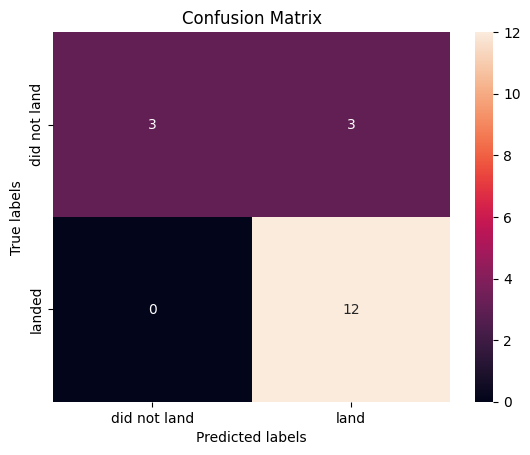

In [20]:
plot_confusion_matrix(y_true, yhat_best_lr)

Examining the confusion matrix, we see that logistic regression allows us to distinguish between the different classes. The problem lies in false positives.

Summary:

True positive - 12 (The true label is obtained, the predicted label is also obtained)

False positive - 3 (The true label is not obtained, the predicted label is obtained)


## STEP 6


We create a support vector machine (SVM) object and then create a <code>GridSearchCV</code> <code>svm_cv</code> object with ``cv = 10``. We tune the object to find the best parameters from the <code>parameters</code> dictionary.

In [28]:
parameters_svm = {
    'kernel':('linear', 'rbf','poly', 'sigmoid'),
    'C': np.logspace(-3, 3, 5),
    'gamma':np.logspace(-3, 3, 5)
    }
svm = SVC()

In [29]:
svm_cv = GridSearchCV(svm, parameters_svm, cv=10)
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'sigmoid')})

In [30]:
print("Optimized performance parameters: (better parameters)",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

Optimized performance parameters: (better parameters) {'C': np.float64(1.0), 'gamma': np.float64(0.03162277660168379), 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## STEP 7


We calculate the accuracy on the test data using the method <code>accuracy_score()</code>:


In [31]:
best_svm = svm_cv.best_estimator_
yhat_best_svm = best_svm.predict(X_test)
accuracy_best_svm = accuracy_score(y_true, yhat_best_svm)
print(f"Report: {classification_report(y_true, yhat_best_svm)}")

Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



We can graph the confusion matrix


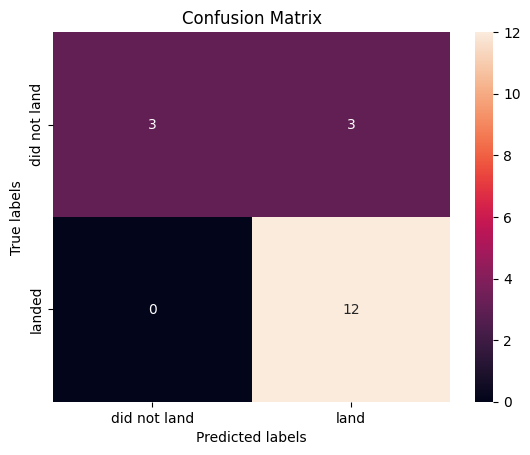

In [26]:
plot_confusion_matrix(y_true, yhat_best_svm)

## STEP 8


We create a decision tree classifier object and then a <code>GridSearchCV</code> and <code>tree_cv</code> object with cv = 10. We will tune the object to find the best parameters from the <code>parameters</code> dictionary.

In [32]:
parameters_tree = {
     'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]
}

tree = DecisionTreeClassifier()

In [33]:
tree_cv = GridSearchCV(tree, parameters_tree, cv=10)
tree_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [34]:
print("Optimized performance parameters: (better parameters)",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

Optimized performance parameters: (better parameters) {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.8875


## STEP 9

We calculate the ``accuracy of tree_cv`` on the test data using the <code>accuracy_score()</code> method:

In [35]:
best_tree = tree_cv.best_estimator_
yhat_best_tree = best_tree.predict(X_test)
accuracy_best_tree = accuracy_score(y_true, yhat_best_tree)
print(f"Report: {classification_report(y_true, yhat_best_tree)}")

Report:               precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.77      0.83      0.80        12

    accuracy                           0.72        18
   macro avg       0.68      0.67      0.67        18
weighted avg       0.71      0.72      0.72        18



We can graph the confusion matrix


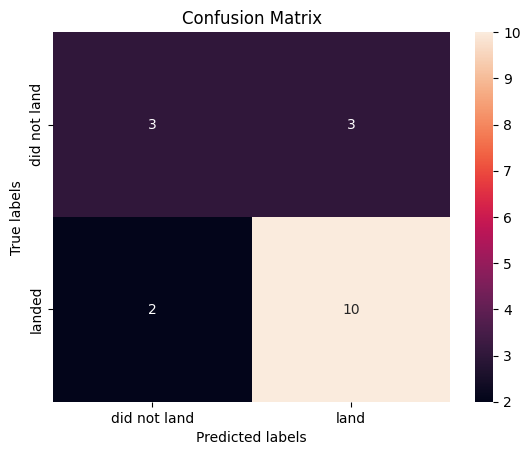

In [36]:
plot_confusion_matrix(y_true, yhat_best_tree)

## STEP 10

We create a k nearest neighbors object and then a <code>GridSearchCV</code> <code>knn_cv</code> object with cv = 10. We tune the object to find the best parameters from the <code>parameters</code> dictionary.

In [37]:
parameters_knn = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1,2]
    }
knn = KNeighborsClassifier()

In [38]:
knn_cv = GridSearchCV(knn, parameters_knn, cv=10)
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [39]:
print("Optimized performance parameters: (better parameters)",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

Optimized performance parameters: (better parameters) {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## STEP 11

We calculate the ``knn_cv accuracy`` on the test data using the <code>accuracy_score()</code> method:

In [46]:
best_knn = knn_cv.best_estimator_
yhat_best_knn = best_knn.predict(X_test)
accuracy_best_knn = accuracy_score(y_true, yhat_best_knn)
print(f"Report: {classification_report(y_true, yhat_best_knn)}")

Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



We can graph the confusion matrix


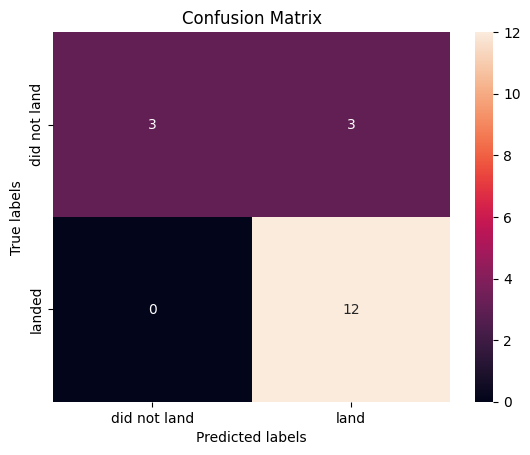

In [47]:
plot_confusion_matrix(y_true, yhat_best_knn)

## STEP 12

We create a Random Forest Classifier object and then a <code>GridSearchCV</code> <code>RFC</code> object with cv = 10. We tune the object to find the best parameters from the <code>parameters</code> dictionary.

In [42]:
rf = RandomForestClassifier(random_state=42)

In [43]:
parameters_rf = {
    'n_estimators': [100, 200],       # Cantidad de árboles en el bosque
    'max_depth': [None, 10, 20],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],       # Mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2],         # Mínimo de muestras en una hoja
    'max_features': ['auto', 'sqrt', 'log2'], # Cantidad de features consideradas en cada split
    'bootstrap': [True, False],            # Si se usa muestreo con reemplazo
    'criterion': ['gini', 'entropy']       # Función de impureza
}

rf_cv = GridSearchCV(rf, parameters_rf, cv=10)
rf_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [48]:
best_rf = rf_cv.best_estimator_
yhat_best_rf = best_rf.predict(X_test)
accuracy_best_rf = accuracy_score(y_true, yhat_best_rf)
print(f"Accuracy score: {accuracy_best_rf:.4f}")
print(f"Report: {classification_report(y_true, yhat_best_rf)}")

Accuracy score: 0.8333
Report:               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



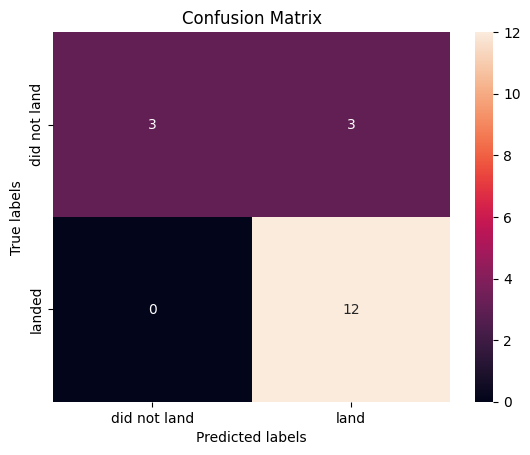

In [49]:
plot_confusion_matrix(y_true, yhat_best_rf)

## STEP 13

We look for the model that best fits the data


In [50]:
from sklearn.metrics import classification_report

models = {
    'KNN': best_knn,
    'Decision Tree': best_tree,
    'Random Forest': best_rf,
    'SVM': best_svm,
    'Logistic Regression': best_lr,
}

results = {}

for name_model, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_true, y_pred)
    print(f'\n {name_model.upper()} results:')
    print("Accuracy:", acc)
    print(classification_report(y_true, y_pred))
    results[name_model] = acc

best_model = max(results, key=results.get)
print(f"\n✅ Best model according to Accuracy: {best_model} ({results[best_model]:.2f})")



 KNN results:
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18


 DECISION TREE results:
Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.77      0.83      0.80        12

    accuracy                           0.72        18
   macro avg       0.68      0.67      0.67        18
weighted avg       0.71      0.72      0.72        18


 RANDOM FOREST results:
Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.80      1.00      0.89        12

    accuracy                  

We visualize in a bar graph:

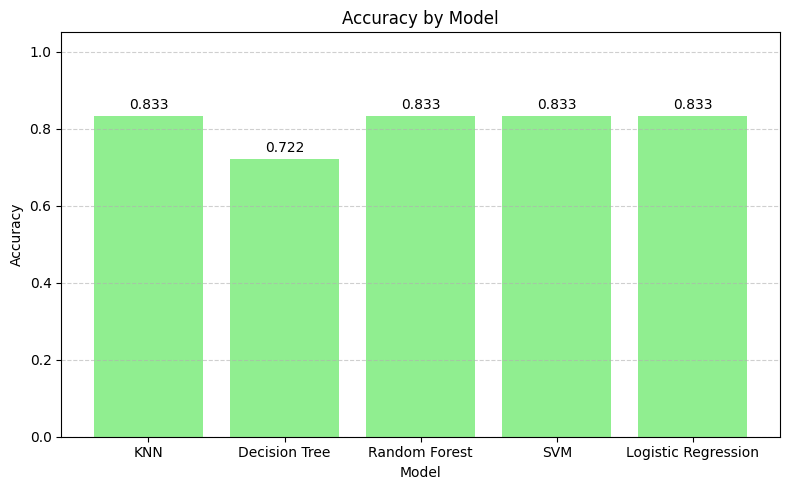

In [52]:
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color='lightgreen')
plt.ylim(0, 1.05)
plt.title('Accuracy by Model')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# We added labels with values ​​above the bars.
for i, (name_model, acc) in enumerate(results.items()):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

<hr>

## <center> Final Conclusion <center>

<div style="padding:10px; background-color:green; border-left:6px solidrgb(78, 116, 240);">
<strong>Various classification algorithms were used, most achieving an accuracy of 83%, with a slight advantage for the model using KNN. Multiple factors influencing landing success were identified, confirming that this outcome can be predicted through measurable patterns. This approach demonstrates the true applicability of machine learning in the aerospace industry.</strong> .
</div>


<br>

<hr>

## Author

<a href="https://www.linkedin.com/in/flavio-aguirre-12784a252/">Flavio Aguirre</a><br>
Data Scientist


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
